In [1]:
import os

In [2]:
import pandas as pd


In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt

In [5]:
import seaborn as sns

In [6]:
from matplotlib.image import imread

In [7]:
my_data_dir = r"C:\Users\Dhananjay\Desktop\cell_images"

In [8]:
os.listdir(my_data_dir) 

['test', 'train']

In [9]:
test_path = my_data_dir+'\\test\\'
train_path = my_data_dir+'\\train\\'

In [10]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [11]:
os.listdir(train_path)

['parasitized', 'uninfected']

In [12]:
os.listdir(train_path+'\\parasitized')[0]

'C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [13]:
para_cell = train_path+'\\parasitized'+'\\C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [14]:
para_img= imread(para_cell)

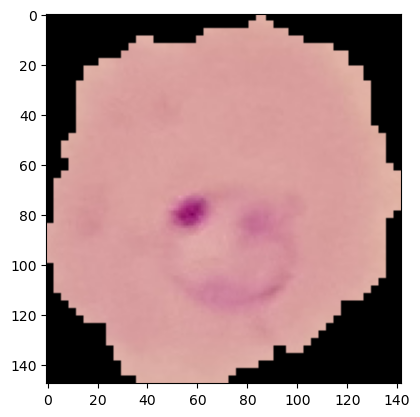

In [15]:
plt.imshow(para_img)

In [16]:
para_img.shape

(148, 142, 3)

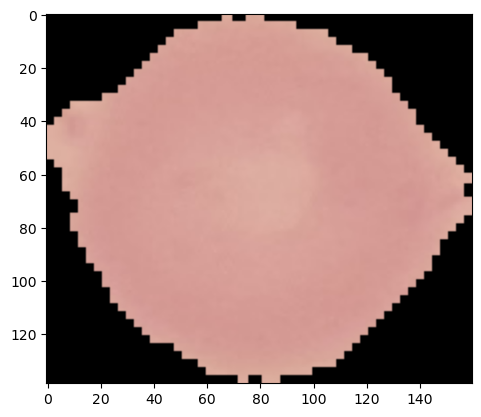

In [17]:
unifected_cell_path = train_path+'\\uninfected\\'+os.listdir(train_path+'\\uninfected')[0]
unifected_cell = imread(unifected_cell_path)
plt.imshow(unifected_cell)

In [18]:
# All images are not necessarily the same shape.
# Images vary from about 50*60 to above 200*200 as seen in the scatterplot below
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'\\uninfected'):
    
    img = imread(test_path+'\\uninfected'+'\\'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

c:\Users\Dhananjay\miniconda3\envs\atomicloops\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


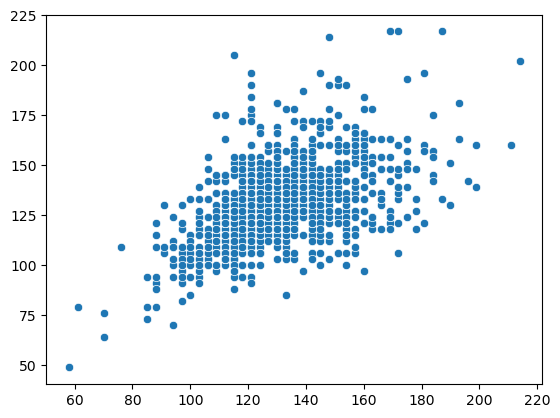

In [19]:
sns.scatterplot(dim1,dim2);

In [20]:
np.mean(dim1), np.mean(dim2)

(130.92538461538462, 130.75)

In [21]:
# The mean dimensions seem to be 130*130 
# Thus it makes sense to resize all the images to 130*130*colours
image_shape = (130,130,3)

## Prepare data 

In [22]:
print(f"we will be dealing with  {130*130*3}  data points")

we will be dealing with  50700  data points


In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [24]:
image_gen = ImageDataGenerator(rotation_range=20, 
                               width_shift_range=0.10, 
                               height_shift_range=0.10, 
                               rescale=1/255, 
                               shear_range=0.1, 
                               zoom_range=0.1, 
                               horizontal_flip=True, 
                               fill_mode='nearest' 
                              )

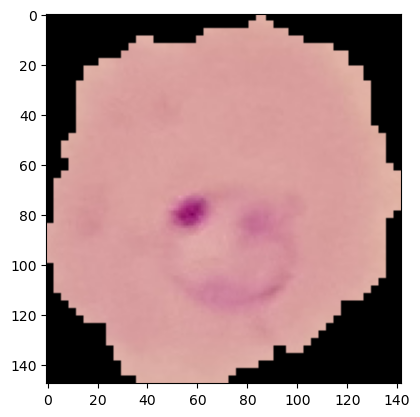

In [25]:
plt.imshow(para_img)

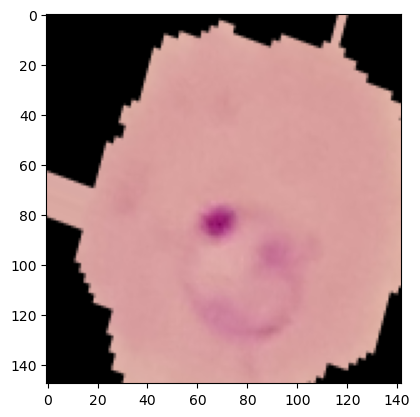

In [26]:
plt.imshow(image_gen.random_transform(para_img))

To use .flow_from_directory method its necessary to organize images in sub-directories like below <br>
<br>
Image data folder --> Class 1 (0.jpg , 1.jpg,. . . . . . , n.jpg) <br>
           |-------> Class 2 (0.jpg , 1.jpg,. . . . . . , n.jpg) <br>
            |------->   : <br>
            :------->   : <br>
            :------->   : <br>

In [27]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [28]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
# Dropout will help avoid overfitting as this is a relatively large network
# They do so by randomly turning off n% neurons

In [32]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [35]:
from tensorflow.keras.callbacks import EarlyStopping

In [36]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

## Training the model

In [37]:
batch_size = 16

In [38]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [39]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


In [40]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [42]:
# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [43]:
results = model.fit_generator(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
1560/1560 [==============================] - 267s 171ms/step - loss: 0.3810 - accuracy: 0.8250 - val_loss: 0.1991 - val_accuracy: 0.9315
Epoch 2/20
1560/1560 [==============================] - 280s 179ms/step - loss: 0.1861 - accuracy: 0.9424 - val_loss: 0.1699 - val_accuracy: 0.9465
Epoch 3/20
1560/1560 [==============================] - 320s 205ms/step - loss: 0.1687 - accuracy: 0.9464 - val_loss: 0.1715 - val_accuracy: 0.9400
Epoch 4/20
1560/1560 [==============================] - 296s 190ms/step - loss: 0.1597 - accuracy: 0.9492 - val_loss: 0.1660 - val_accuracy: 0.9454
Epoch 5/20
1560/1560 [==============================] - 295s 189ms/step - loss: 0.1607 - accuracy: 0.9503 - val_loss: 0.1504 - val_accuracy: 0.9496
Epoch 6/20
1560/1560 [==============================] - 283s 181ms/step - loss: 0.1615 - accuracy: 0.9484 - val_loss: 0.2047 - val_accuracy: 0.9265
Epoch 7/20
1560/1560 [==============

In [50]:
from tensorflow.keras.models import load_model
model.save('malaria_prediction.h5')

## Model Evaluation

In [51]:
losses = pd.DataFrame(model.history.history)

In [52]:
losses

,loss,accuracy,val_loss,val_accuracy
0,0.381038,0.825026,0.199064,0.931538
1,0.186055,0.942423,0.169948,0.946538
2,0.168655,0.946430,0.171498,0.940000
3,0.159685,0.949195,0.166035,0.945385
4,0.160750,0.950276,0.150374,0.949615
5,0.161498,0.948433,0.204702,0.926538
6,0.153458,0.951398,0.148466,0.949231
7,0.149822,0.950958,0.164528,0.941154
8,0.156360,0.950036,0.141280,0.950000
9,0.151138,0.950477,0.155082,0.950769


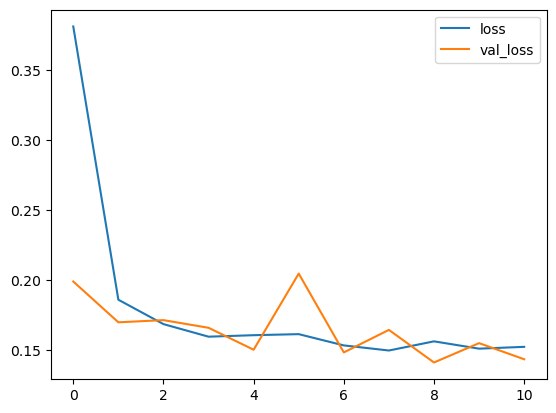

In [54]:
losses[['loss','val_loss']].plot();

In [55]:
model.evaluate_generator(test_image_gen)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.14380264282226562, 0.9519230723381042]

Above evaluation suggests that the model has 95.1923% accuracy with a loss of 0.1438<br>
It is useful to add an accuracy metric to the model as it makes it easier to interpret how well the model is performing.<br>
It is difficult to tell that by only looking at the loss. 

In [56]:
from tensorflow.keras.preprocessing import image

In [57]:
pred_probabilities = model.predict_generator(test_image_gen)

Instructions for updating:
Please use Model.predict, which supports generators.


In [58]:
pred_probabilities

array([[2.7281046e-04],
       [4.5284629e-04],
       [2.2905149e-05],
       ...,
       [9.5864505e-01],
       [9.9054378e-01],
       [9.5816994e-01]], dtype=float32)

In [59]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1])

In [60]:
predictions = pred_probabilities > 0.5
predictions

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [61]:
from sklearn.metrics import classification_report,confusion_matrix

In [62]:
print(classification_report(test_image_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1300
           1       0.94      0.97      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [63]:
confusion_matrix(test_image_gen.classes,predictions)

array([[1213,   87],
       [  39, 1261]], dtype=int64)

In [64]:
malaria_model = load_model('malaria_prediction.h5')

In [65]:
malaria_model